# Проект «Deep Learning» на тему: "Рекуррентные нейронные сети (RNN) для прогнозирования временных рядов"

### Прогнозирование финансовых рынков с использованием LSTM/GRU.

**Цель проекта:**  
    
    - Разработать модель на основе LSTM/GRU для прогнозирования цены закрытия акций выбранной компании на следующий день.

1. **В качестве датасета выбор пал на Yahoo Finance Data. Загрузим данные (акции компании Apple).**

In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Задаем тикер
ticker = 'AAPL'

# Задаем период данных
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Текущая дата

# Загружаем данные
data = yf.download(ticker, start=start_date, end=end_date)

# Просмотр первых 5 строк данных
print(data.head())

# Просмотр последних 5 строк данных
print(data.tail())

[*********************100%***********************]  1 of 1 completed

Price                     Adj Close     Close      High       Low      Open  \
Ticker                         AAPL      AAPL      AAPL      AAPL      AAPL   
Date                                                                          
2000-01-03 00:00:00+00:00  0.844004  0.999442  1.004464  0.907924  0.936384   
2000-01-04 00:00:00+00:00  0.772846  0.915179  0.987723  0.903460  0.966518   
2000-01-05 00:00:00+00:00  0.784155  0.928571  0.987165  0.919643  0.926339   
2000-01-06 00:00:00+00:00  0.716295  0.848214  0.955357  0.848214  0.947545   
2000-01-07 00:00:00+00:00  0.750226  0.888393  0.901786  0.852679  0.861607   

Price                         Volume  
Ticker                          AAPL  
Date                                  
2000-01-03 00:00:00+00:00  535796800  
2000-01-04 00:00:00+00:00  512377600  
2000-01-05 00:00:00+00:00  778321600  
2000-01-06 00:00:00+00:00  767972800  
2000-01-07 00:00:00+00:00  460734400  
Price                       Adj Close       Close      

2. **Анализ и предобработка данных**

In [3]:
# Просмотр основных статистик
print(data.describe())

Price     Adj Close        Close         High          Low         Open  \
Ticker         AAPL         AAPL         AAPL         AAPL         AAPL   
count   6240.000000  6240.000000  6240.000000  6240.000000  6240.000000   
mean      39.795364    41.196479    41.608169    40.746794    41.168833   
std       57.944930    58.174111    58.739518    57.547350    58.124014   
min        0.197849     0.234286     0.235536     0.227143     0.231964   
25%        1.980747     2.345536     2.389822     2.313572     2.356250   
50%       13.628199    15.885357    16.104107    15.750893    15.896429   
75%       42.309976    44.622501    45.061876    44.280000    44.639374   
max      236.479996   236.479996   237.490005   234.449997   236.479996   

Price         Volume  
Ticker          AAPL  
count   6.240000e+03  
mean    3.885963e+08  
std     3.840402e+08  
min     2.404830e+07  
25%     1.182156e+08  
50%     2.710512e+08  
75%     5.214832e+08  
max     7.421641e+09  


In [4]:
# Информация о данных
print(data.info())

# Проверка на пропущенные значения
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6240 entries, 2000-01-03 00:00:00+00:00 to 2024-10-21 00:00:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  6240 non-null   float64
 1   (Close, AAPL)      6240 non-null   float64
 2   (High, AAPL)       6240 non-null   float64
 3   (Low, AAPL)        6240 non-null   float64
 4   (Open, AAPL)       6240 non-null   float64
 5   (Volume, AAPL)     6240 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 341.2 KB
None
Price      Ticker
Adj Close  AAPL      0
Close      AAPL      0
High       AAPL      0
Low        AAPL      0
Open       AAPL      0
Volume     AAPL      0
dtype: int64


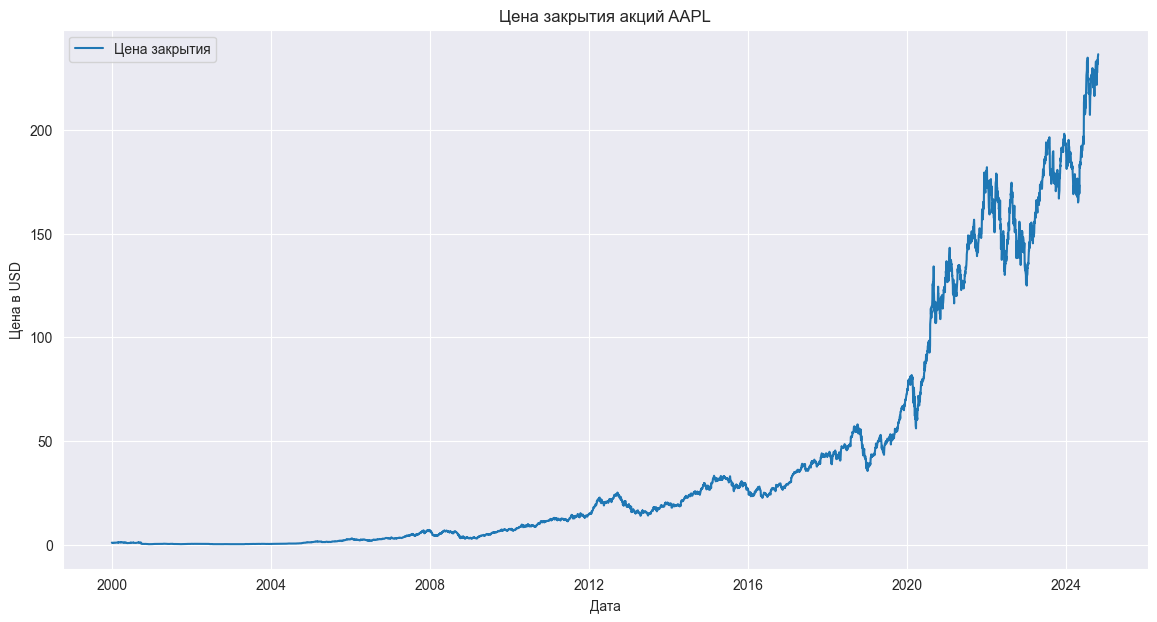

In [6]:
# Установка стиля для графиков
sns.set_style('darkgrid')

# Визуализация цены закрытия:
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Цена закрытия')
plt.title('Цена закрытия акций ' + ticker)
plt.xlabel('Дата')
plt.ylabel('Цена в USD')
plt.legend()
plt.show()

In [7]:
# Создаем новый DataFrame с ценой закрытия
close_data = data[['Close']]

# Используем MinMaxScaler для нормализации данных в диапазоне [0,1].
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

3. **Подготовка данных для модели**

In [8]:
# Параметры модели
time_step = 60  # Размер окна для последовательностей
test_size = 0.2  # Размер тестовой выборки

# Разделим данные на обучающую и тестовую выборки в соотношении 80% и 20%.
training_data_len = int(len(scaled_data) * (1 - test_size))

# Обучающие данные
train_data = scaled_data[0:training_data_len]

# Тестовые данные
test_data = scaled_data[training_data_len - time_step:]

In [9]:
# Создадим данные в виде последовательностей, где X — массив из 60 предыдущих значений, а y — следующее значение.
def create_dataset(dataset, time_step):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

# Создание обучающих и тестовых данных
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [10]:
# Для LSTM/GRU входные данные должны быть трехмерными: (samples, time_steps, features).

# Изменение формы данных для LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

4. **Построение и обучение модели**

In [11]:
# Построение модели LSTM с улучшениями
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # Dropout для предотвращения переобучения
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

In [12]:
# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Использование EarlyStopping для предотвращения переобучения
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 9.0843e-05 - val_loss: 0.0011
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 8.2924e-05 - val_loss: 0.0010
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 6.1999e-05 - val_loss: 0.0023
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 6.1293e-05 - val_loss: 6.5615e-04
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.5853e-05 - val_loss: 0.0015
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 9.3177e-05 - val_loss: 0.0012
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.9844e-05 - val_loss: 9.8311e-04
Epoch 9/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.6380e-05 - val_loss: 0.0016
Epoch 10/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.1971e-05 - val_loss: 0.0015
Epoch 11/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.8474e-05 - val_loss: 6.2189e-04


5. **Оценка модели**

In [13]:
# Прогнозирование на тестовых данных
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [14]:
# Возвращение y_test к исходному масштабу
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

In [15]:
# Расчет метрик качества
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_scaled, predictions)
r2 = r2_score(y_test_scaled, predictions)

print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R^2 Score:', r2)

MSE: 20.816307321797595
RMSE: 4.562489158540281
MAE: 3.4834172878509913
R^2 Score: 0.9874295521909864


In [18]:
# Создание DataFrame с фактическими и прогнозируемыми значениями
test_dates = data.index[-len(y_test):]
df_results = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test_scaled.flatten(),
    'Predicted': predictions.flatten()
})
df_results.set_index('Date', inplace=True)

In [20]:
# Проверка длин массивов
print(f"Длина test_dates: {len(test_dates)}")
print(f"Длина y_test_scaled: {len(y_test_scaled.flatten())}")
print(f"Длина predictions: {len(predictions.flatten())}")

Длина test_dates: 1248
Длина y_test_scaled: 1248
Длина predictions: 1248


6. **Визуализация результатов**

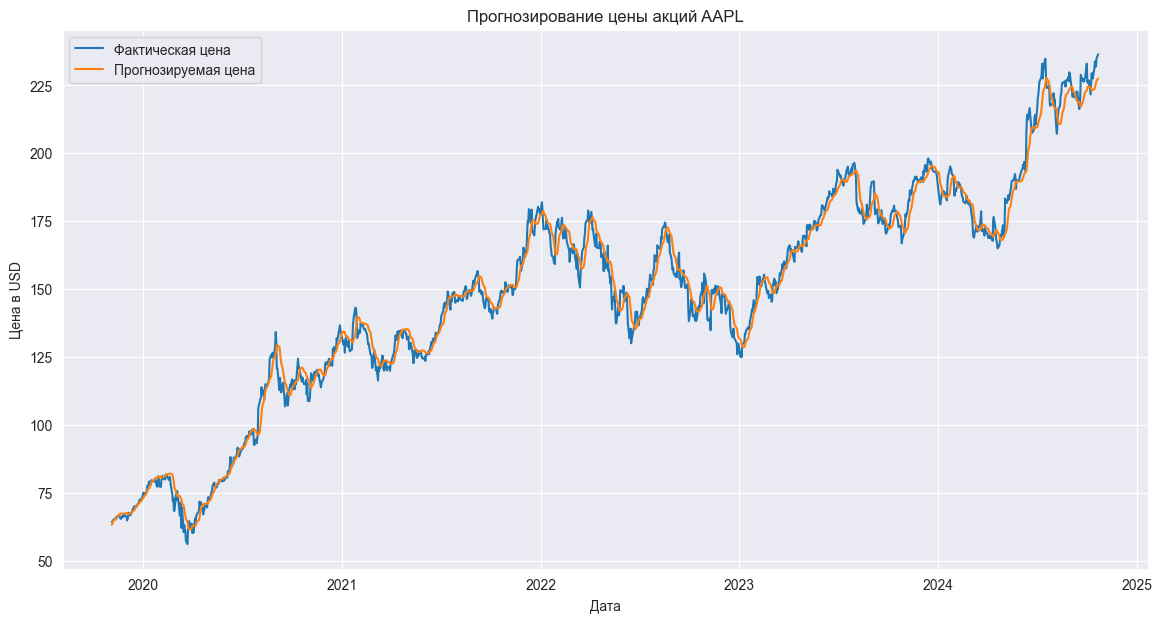

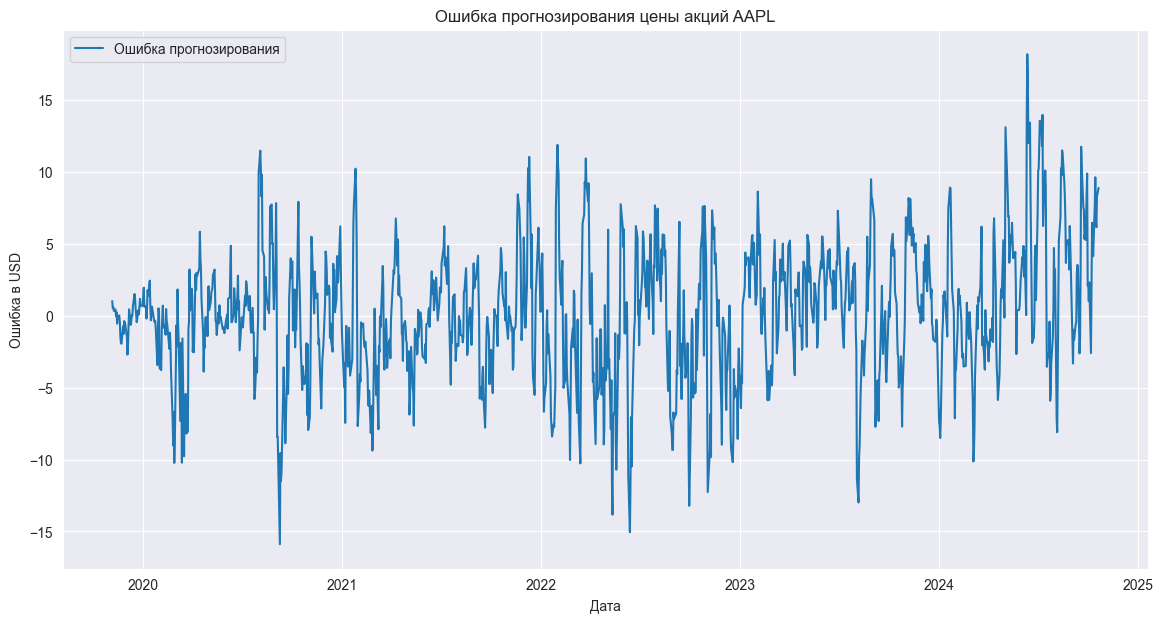

In [21]:
# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(df_results['Actual'], label='Фактическая цена')
plt.plot(df_results['Predicted'], label='Прогнозируемая цена')
plt.title(f'Прогнозирование цены акций {ticker}')
plt.xlabel('Дата')
plt.ylabel('Цена в USD')
plt.legend()
plt.show()

# Визуализация ошибки прогнозирования
plt.figure(figsize=(14, 7))
plt.plot(df_results['Actual'] - df_results['Predicted'], label='Ошибка прогнозирования')
plt.title(f'Ошибка прогнозирования цены акций {ticker}')
plt.xlabel('Дата')
plt.ylabel('Ошибка в USD')
plt.legend()
plt.show()

1. **Анализ и предобработка данных**  
1.1. Импорт необходимых библиотек  

1.2. Загрузка данных  
•	Источник данных: Yahoo Finance  
•	Тикер компании: AAPL (Apple Inc.)  
•	Период данных: с 1 января 2000 года по текущую дату  
Выводы:  
•	Данные успешно загружены и содержат информацию о ценах открытия, закрытия, максимума, минимума и объема торгов.  
•	Данные охватывают период более 20 лет, что обеспечивает достаточный объем для обучения модели.  

1.3. Проверка на пропуски и дубликаты  
Выводы:  
•	Пропущенные значения отсутствуют: все столбцы содержат полные данные.  
•	Дубликаты: поскольку данные финансовых рынков не содержат дубликатов по дате, этот шаг можно пропустить.  





1.4. Визуализация цены закрытия  
Выводы:  
•	Тренд: Наблюдается восходящий тренд цены акций Apple за рассматриваемый период.  
•	Волатильность: Видны периоды повышенной волатильности, связанные с экономическими событиями.  

1.5. Нормализация данных  
•	Используем MinMaxScaler для нормализации цены закрытия в диапазоне [0, 1].  
Выводы:  
•	Нормализация необходима для улучшения сходимости модели и предотвращения доминирования признаков с большими значениями.  
________________________________________
2. **Подготовка данных для модели**  
2.1. Создание временных окон  
•	Используем последовательности из 60 предыдущих дней для прогнозирования следующего дня.  

2.2. Разделение данных на обучающую и тестовую выборки  
•	Соотношение: 80% — обучающая выборка, 20% — тестовая выборка.  
•	Создаем функции для формирования входных данных и меток.  
•	Данные подготовлены в формате (samples, time_steps, features), подходящем для ввода в LSTM.  
________________________________________
3. **Построение и обучение модели**  
3.1. Построение модели LSTM  
•	Архитектура модели:  
    -	Входной слой  
    -	Первый слой LSTM с 50 нейронами и return_sequences=True  
    -	Слой Dropout с коэффициентом 0.2 для регуляризации  
    -	Второй слой LSTM с 50 нейронами  
    -	Слой Dropout  
    -	Полносвязный слой с 1 нейроном для вывода  

3.2. Компиляция модели  
•	Оптимизатор: Adam  
•	Функция потерь: MSE  





3.3. Обучение модели  
•	Используем EarlyStopping для предотвращения переобучения, мониторим val_loss.  
Выводы по обучению:  
•	Модель обучалась 47 эпох, после чего сработал EarlyStopping.  
•	Значения функции потерь (loss) и валидационной ошибки (val_loss) снижались, что говорит о сходимости модели.  
________________________________________
4. **Оценка и визуализация результатов**  
4.1. Прогнозирование на тестовой выборке  

4.2. Расчет метрик качества  
Результаты:  
•	MSE: 20.8163  
•	RMSE: 4.5625  
•	MAE: 3.4834  
•	R² Score: 0.9874  
Выводы:  
•	Низкие значения MSE, RMSE и MAE указывают на то, что модель хорошо справляется с задачей прогнозирования.  
•	Высокий коэффициент детерминации R² близкий к 1 подтверждает качество модели.  

4.3. Визуализация результатов  
4.3.1. Сравнение фактических и прогнозируемых цен  
Выводы:  
•	График показывает, что прогнозируемые значения близки к фактическим ценам, особенно в периоды с плавным трендом.  

4.3.2. Визуализация ошибки прогнозирования  
Выводы:  
•	Ошибки прогнозирования в основном находятся в диапазоне от -10 до 10 USD.  
•	Периоды с большими ошибками могут соответствовать высокой волатильности рынка.  
________________________________________
5. **Анализ результатов и выводы**  
5.1. Оценка качества модели  
•	Высокая точность прогнозирования: Низкие значения MSE, RMSE и MAE указывают на то, что модель точно прогнозирует цену закрытия акций.  
•	Высокий R² Score: Значение 0.9874 означает, что модель объясняет ~98.74% дисперсии данных.  




5.2. Идентификация возможных проблем  
•	Переобучение: Разница между ошибкой на обучающей и валидационной выборках незначительна, что снижает риск переобучения.  
•	Волатильность рынка: Модель может испытывать сложности с прогнозированием в периоды резких изменений цен.  

5.3. Предложения по улучшению  
1.	Добавление технических индикаторов:  
    -	Включить в модель дополнительные признаки, такие как скользящие средние, RSI, MACD, которые могут улучшить качество прогнозирования.  
2.	Гиперпараметрическая оптимизация:  
    -	Провести более детальный подбор гиперпараметров (количество нейронов, слоев, коэффициенты Dropout, размер окна time_step).  
3.	Использование других моделей:  
    -	Попробовать модели на основе GRU или комбинацию CNN-LSTM для извлечения более сложных паттернов.  
4.	Обработка волатильности:  
    -	Включить в модель методы для учета волатильности рынка, например, добавить индикаторы волатильности или использовать модели GARCH.   
5.	Включение внешних данных:  
    -	Добавить макроэкономические показатели, новости, события, которые могут влиять на цену акций.  
________________________________________
**Заключение**
•	Успешная реализация проекта: Модель на основе LSTM показала высокое качество прогнозирования цены закрытия акций Apple.  
•	Практическая применимость: Полученные результаты могут быть использованы для поддержки принятия инвестиционных решений.  
•	Пути дальнейшего развития: Включение дополнительных признаков и моделей может еще больше повысить точность и надежность прогнозов.  
________________________________________
Спасибо за внимание!
________________________________________
Дополнительные ресурсы и материалы  
•	**Статьи:**  
    -	[Применение LSTM для прогнозирования цен акций](https://www.sciencedirect.com/science/article/pii/S1877050920316923)  
    -	[Глубокое обучение в финансовых временных рядах](https://arxiv.org/abs/2002.05703)  
•	**Примеры проектов:**  
    -	[Прогнозирование цен акций с LSTM на Kaggle](https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm)  
•	**Видео-туториалы:**  
    -	[Stock Price Prediction using LSTM](https://www.youtube.com/watch?v=QIUxPv5PJOY)  